# Hyperparameter Tuning with MLflow

The objective of this notebook is to fine-tune top models and track experiments with MLflow

Contents:
1. Load Baseline Results and Data
2. Select Top 3 Models for Tuning
3. Define Hyperparameter Grids
4. GridSearchCV with MLflow Tracking
5. Best Parameter Selection
6. Performance Comparison (Tuned vs Baseline)
7. Save Best Tuned Model

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, make_scorer)
import joblib

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning, module='mlflow')

In [3]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Define project paths
ROOT = Path.cwd().parent if (Path.cwd().parent / 'data').exists() else Path.cwd()
DATA_PROC = ROOT / "data" / "processed"
MODELS = ROOT / "models"
REPORTS = ROOT / "reports"
FIGS = REPORTS / "figures"

# Create directories
for p in [MODELS, FIGS]:
    p.mkdir(parents=True, exist_ok=True)

print(f"\nProject Root: {ROOT}")
print(f"Data Processed: {DATA_PROC}")
print(f"Models: {MODELS}")
print(f"Figures: {FIGS}")


Project Root: /Users/lia/Desktop/Fase1
Data Processed: /Users/lia/Desktop/Fase1/data/processed
Models: /Users/lia/Desktop/Fase1/models
Figures: /Users/lia/Desktop/Fase1/reports/figures


## Load Data and Baseline Results

In [5]:
# Load training and test data
train_data = pd.read_csv(DATA_PROC / 'student_performance_train.csv')
test_data = pd.read_csv(DATA_PROC / 'student_performance_test.csv')

# Separate features and target
X_train = train_data.drop('Performance_Binary', axis=1)
y_train = train_data['Performance_Binary']
X_test = test_data.drop('Performance_Binary', axis=1)
y_test = test_data['Performance_Binary']

print(f"\nData loaded successfully")
print(f" Training samples: {len(X_train)}")
print(f" Test samples: {len(X_test)}")
print(f" Features: {X_train.shape[1]}")

# Load baseline results
baseline_results_path = REPORTS / "model_comparison_results.csv"
if baseline_results_path.exists():
    baseline_results = pd.read_csv(baseline_results_path)
    print(f"\n✓Baseline results loaded")
    print(f"\nTop 3 Baseline Models:")
    print(baseline_results[['Model', 'Test Accuracy', 'CV Mean']].head(3).to_string(index=False))
else:
    print(f"\n⚠Baseline results not found. Run notebook 04 first.")
    baseline_results = None


Data loaded successfully
 Training samples: 497
 Test samples: 125
 Features: 30

✓Baseline results loaded

Top 3 Baseline Models:
              Model  Test Accuracy  CV Mean
Logistic Regression          0.704 0.706343
      Random Forest          0.704 0.641717
                SVM          0.704 0.678141


## MLflow Setup

In [7]:
# Set MLflow tracking URI
mlflow_dir = ROOT / "mlruns"
mlflow.set_tracking_uri(f"file://{mlflow_dir}")

# Set experiment name
experiment_name = "student_performance_tuning"
mlflow.set_experiment(experiment_name)

print(f"\n✓ MLflow configured")
print(f"  Tracking URI: {mlflow.get_tracking_uri()}")
print(f"  Experiment: {experiment_name}")


✓ MLflow configured
  Tracking URI: file:///Users/lia/Desktop/Fase1/mlruns
  Experiment: student_performance_tuning


## Select Top 3 Models for Tuning

In [8]:
# Define models and their parameter grids
models_to_tune = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'liblinear', 'saga']
        },
        'description': 'Simple linear classifier with regularization'
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        },
        'description': 'Ensemble of decision trees'
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        },
        'description': 'Support Vector Machine with kernel trick'
    }
}

print(f"\nSelected {len(models_to_tune)} models for hyperparameter tuning:")
for i, (name, info) in enumerate(models_to_tune.items(), 1):
    n_combinations = np.prod([len(v) for v in info['params'].values()])
    print(f"\n{i}. {name}")
    print(f"   → {info['description']}")
    print(f"   → Parameter combinations: {n_combinations}")
    print(f"   → Hyperparameters to tune:")
    for param, values in info['params'].items():
        print(f"      • {param}: {values}")


Selected 3 models for hyperparameter tuning:

1. Logistic Regression
   → Simple linear classifier with regularization
   → Parameter combinations: 18
   → Hyperparameters to tune:
      • C: [0.001, 0.01, 0.1, 1, 10, 100]
      • penalty: ['l2']
      • solver: ['lbfgs', 'liblinear', 'saga']

2. Random Forest
   → Ensemble of decision trees
   → Parameter combinations: 216
   → Hyperparameters to tune:
      • n_estimators: [50, 100, 200]
      • max_depth: [5, 10, 15, None]
      • min_samples_split: [2, 5, 10]
      • min_samples_leaf: [1, 2, 4]
      • max_features: ['sqrt', 'log2']

3. SVM
   → Support Vector Machine with kernel trick
   → Parameter combinations: 16
   → Hyperparameters to tune:
      • C: [0.1, 1, 10, 100]
      • kernel: ['linear', 'rbf']
      • gamma: ['scale', 'auto']


## Hyperparameter Tuning with GridSearchCV and MLflow

In [10]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store tuning results
tuning_results = []
best_models = {}

print(f"\nStarting hyperparameter tuning with MLflow tracking...")
print(f" • Method: GridSearchCV")
print(f" • CV Folds: 5")
print(f" • Scoring: Accuracy")
print(f" • n_jobs: -1 (parallel processing)\n")

for model_name, model_info in models_to_tune.items():
    print(f"{'='*80}")
    print(f"TUNING: {model_name}")
    print(f"{'='*80}")
    
    model = model_info['model']
    param_grid = model_info['params']
    
    # Calculate total combinations
    n_combinations = np.prod([len(v) for v in param_grid.values()])
    print(f"\n→ Testing {n_combinations} parameter combinations...")
    print(f"→ This will create {n_combinations} MLflow runs (one per combination)")
    print(f"→ Estimated time: ~{n_combinations * 2} seconds\n")
    
    # Parent run for this model's tuning
    with mlflow.start_run(run_name=f"{model_name}_tuning_parent") as parent_run:
        
        # Log parent run info
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("tuning_method", "GridSearchCV")
        mlflow.log_param("cv_folds", 5)
        mlflow.log_param("n_combinations", n_combinations)
        
        # GridSearchCV with nested MLflow runs
        print(f"→ Running GridSearchCV...")
        
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1,
            return_train_score=True
        )
        
        # Fit grid search
        grid_search.fit(X_train, y_train)
        
        print(f"\n✓ GridSearchCV complete!")
        print(f"\n  Best Parameters:")
        for param, value in grid_search.best_params_.items():
            print(f"   • {param}: {value}")
        
        print(f"\n  Best CV Score: {grid_search.best_score_:.4f}")
        
        # Log best parameters
        for param, value in grid_search.best_params_.items():
            mlflow.log_param(f"best_{param}", value)
        mlflow.log_metric("best_cv_score", grid_search.best_score_)
        
        # Get best model
        best_model = grid_search.best_estimator_
        
        # Evaluate best model on test set
        print(f"\n→ Evaluating best model on test set...")
        test_pred = best_model.predict(X_test)
        test_pred_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None
        
        # Calculate test metrics
        test_accuracy = accuracy_score(y_test, test_pred)
        test_precision = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        
        print(f" ✓ Test Accuracy: {test_accuracy:.4f}")
        print(f" ✓ Test Precision: {test_precision:.4f}")
        print(f" ✓ Test Recall: {test_recall:.4f}")
        print(f" ✓ Test F1-Score: {test_f1:.4f}")
        
        # Log test metrics
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall", test_recall)
        mlflow.log_metric("test_f1", test_f1)
        
        # Log ROC-AUC if available
        if test_pred_proba is not None:
            test_roc_auc = roc_auc_score(y_test, test_pred_proba)
            print(f" ✓ Test ROC-AUC: {test_roc_auc:.4f}")
            mlflow.log_metric("test_roc_auc", test_roc_auc)
        else:
            test_roc_auc = None
        
        # Log top 5 parameter combinations as nested runs
        print(f"\n → Logging top 5 parameter combinations to MLflow...")
        cv_results = pd.DataFrame(grid_search.cv_results_)
        cv_results = cv_results.sort_values('rank_test_score')
        
        for idx, row in cv_results.head(5).iterrows():
            with mlflow.start_run(run_name=f"{model_name}_rank_{int(row['rank_test_score'])}", nested=True):
                # Log parameters
                params_dict = row['params']
                for param, value in params_dict.items():
                    mlflow.log_param(param, value)
                
                # Log metrics
                mlflow.log_metric("cv_mean_score", row['mean_test_score'])
                mlflow.log_metric("cv_std_score", row['std_test_score'])
                mlflow.log_metric("rank", row['rank_test_score'])
        
        # Log best model
        signature = infer_signature(X_train, best_model.predict(X_train))
        input_example = X_train.iloc[:5]
        
        mlflow.sklearn.log_model(
            sk_model=best_model,
            artifact_path="model",
            signature=signature,
            input_example=input_example
        )
        
        # Store results
        tuning_results.append({
            'Model': model_name,
            'Best CV Score': grid_search.best_score_,
            'Test Accuracy': test_accuracy,
            'Test Precision': test_precision,
            'Test Recall': test_recall,
            'Test F1': test_f1,
            'Test ROC-AUC': test_roc_auc if test_roc_auc else 0.0,
            'Best Params': str(grid_search.best_params_)
        })
        
        # Store best model
        best_models[model_name] = best_model
        
        print(f"\n{model_name} tuning complete\n")

print(f"{'='*80}")
print("All models tunned successfully")
print(f"{'='*80}")


Starting hyperparameter tuning with MLflow tracking...
 • Method: GridSearchCV
 • CV Folds: 5
 • Scoring: Accuracy
 • n_jobs: -1 (parallel processing)

TUNING: Logistic Regression

→ Testing 18 parameter combinations...
→ This will create 18 MLflow runs (one per combination)
→ Estimated time: ~36 seconds

→ Running GridSearchCV...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


2025/10/23 15:47:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✓ GridSearchCV complete!

  Best Parameters:
   • C: 0.1
   • penalty: l2
   • solver: liblinear

  Best CV Score: 0.7104

→ Evaluating best model on test set...
 ✓ Test Accuracy: 0.7120
 ✓ Test Precision: 0.6792
 ✓ Test Recall: 0.6545
 ✓ Test F1-Score: 0.6667
 ✓ Test ROC-AUC: 0.8139

 → Logging top 5 parameter combinations to MLflow...

Logistic Regression tuning complete

TUNING: Random Forest

→ Testing 216 parameter combinations...
→ This will create 216 MLflow runs (one per combination)
→ Estimated time: ~432 seconds

→ Running GridSearchCV...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


2025/10/23 15:47:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✓ GridSearchCV complete!

  Best Parameters:
   • max_depth: 10
   • max_features: log2
   • min_samples_leaf: 4
   • min_samples_split: 10
   • n_estimators: 200

  Best CV Score: 0.6921

→ Evaluating best model on test set...
 ✓ Test Accuracy: 0.7040
 ✓ Test Precision: 0.6731
 ✓ Test Recall: 0.6364
 ✓ Test F1-Score: 0.6542
 ✓ Test ROC-AUC: 0.8014

 → Logging top 5 parameter combinations to MLflow...

Random Forest tuning complete

TUNING: SVM

→ Testing 16 parameter combinations...
→ This will create 16 MLflow runs (one per combination)
→ Estimated time: ~32 seconds

→ Running GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


2025/10/23 15:47:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✓ GridSearchCV complete!

  Best Parameters:
   • C: 100
   • gamma: scale
   • kernel: linear

  Best CV Score: 0.7083

→ Evaluating best model on test set...
 ✓ Test Accuracy: 0.7200
 ✓ Test Precision: 0.6923
 ✓ Test Recall: 0.6545
 ✓ Test F1-Score: 0.6729
 ✓ Test ROC-AUC: 0.8235

 → Logging top 5 parameter combinations to MLflow...

SVM tuning complete

All models tunned successfully


## Compare Tuned vs Baseline Models

In [12]:
# Create tuning results DataFrame
tuning_df = pd.DataFrame(tuning_results)
tuning_df = tuning_df.sort_values('Test Accuracy', ascending=False)

print(f"\nTUNED MODEL PERFORMANCE:")
print(f"{'='*80}")
print(tuning_df[['Model', 'Best CV Score', 'Test Accuracy', 'Test Precision', 
                 'Test Recall', 'Test F1', 'Test ROC-AUC']].to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# Compare with baseline if available
if baseline_results is not None:
    print(f"\n{'='*80}")
    print("BASELINE VS TUNED COMPARISON")
    print(f"{'='*80}")
    
    comparison_data = []
    for model_name in tuning_df['Model']:
        # Get baseline metrics
        baseline_row = baseline_results[baseline_results['Model'] == model_name]
        if not baseline_row.empty:
            baseline_acc = baseline_row['Test Accuracy'].values[0]
            baseline_cv = baseline_row['CV Mean'].values[0]
        else:
            baseline_acc = 0.0
            baseline_cv = 0.0
        
        # Get tuned metrics
        tuned_row = tuning_df[tuning_df['Model'] == model_name]
        tuned_acc = tuned_row['Test Accuracy'].values[0]
        tuned_cv = tuned_row['Best CV Score'].values[0]
        
        # Calculate improvement
        acc_improvement = tuned_acc - baseline_acc
        cv_improvement = tuned_cv - baseline_cv
        
        comparison_data.append({
            'Model': model_name,
            'Baseline Test Acc': baseline_acc,
            'Tuned Test Acc': tuned_acc,
            'Accuracy Δ': acc_improvement,
            'Baseline CV': baseline_cv,
            'Tuned CV': tuned_cv,
            'CV Δ': cv_improvement
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(f"\n{comparison_df.to_string(index=False, float_format=lambda x: f'{x:.4f}')}")
    
    # Summary statistics
    print(f"\n{'='*80}")
    print("IMPROVEMENT SUMMARY")
    print(f"{'='*80}")
    avg_acc_improvement = comparison_df['Accuracy Δ'].mean()
    avg_cv_improvement = comparison_df['CV Δ'].mean()
    
    print(f"\nAverage Test Accuracy Improvement: {avg_acc_improvement:+.4f} ({avg_acc_improvement*100:+.2f}%)")
    print(f"Average CV Score Improvement: {avg_cv_improvement:+.4f} ({avg_cv_improvement*100:+.2f}%)")
    
    # Best improvement
    best_improvement_idx = comparison_df['Accuracy Δ'].idxmax()
    best_model = comparison_df.loc[best_improvement_idx, 'Model']
    best_improvement = comparison_df.loc[best_improvement_idx, 'Accuracy Δ']
    
    print(f"\nBest Improvement: {best_model}")
    print(f"Accuracy gain: {best_improvement:+.4f} ({best_improvement*100:+.2f}%)")

# Identify overall best tuned model
best_tuned_model_name = tuning_df.iloc[0]['Model']
best_tuned_accuracy = tuning_df.iloc[0]['Test Accuracy']

print(f"\n{'='*80}")
print(f"BEST TUNED MODEL: {best_tuned_model_name}")
print(f"{'='*80}")
print(f"Test Accuracy: {best_tuned_accuracy:.4f} ({best_tuned_accuracy*100:.2f}%)")
print(f"Best CV Score: {tuning_df.iloc[0]['Best CV Score']:.4f}")
print(f"Test F1-Score: {tuning_df.iloc[0]['Test F1']:.4f}")
if tuning_df.iloc[0]['Test ROC-AUC'] > 0:
    print(f"Test ROC-AUC: {tuning_df.iloc[0]['Test ROC-AUC']:.4f}")



TUNED MODEL PERFORMANCE:
              Model  Best CV Score  Test Accuracy  Test Precision  Test Recall  Test F1  Test ROC-AUC
                SVM         0.7083         0.7200          0.6923       0.6545   0.6729        0.8235
Logistic Regression         0.7104         0.7120          0.6792       0.6545   0.6667        0.8139
      Random Forest         0.6921         0.7040          0.6731       0.6364   0.6542        0.8014

BASELINE VS TUNED COMPARISON

              Model  Baseline Test Acc  Tuned Test Acc  Accuracy Δ  Baseline CV  Tuned CV   CV Δ
                SVM             0.7040          0.7200      0.0160       0.6781    0.7083 0.0301
Logistic Regression             0.7040          0.7120      0.0080       0.7063    0.7104 0.0040
      Random Forest             0.7040          0.7040      0.0000       0.6417    0.6921 0.0504

IMPROVEMENT SUMMARY

Average Test Accuracy Improvement: +0.0080 (+0.80%)
Average CV Score Improvement: +0.0282 (+2.82%)

Best Improvement: SVM
Acc

## Visualize Results


Saved visualization to: /Users/lia/Desktop/Fase1/reports/figures/hyperparameter_tuning_results_20251023_155933.png


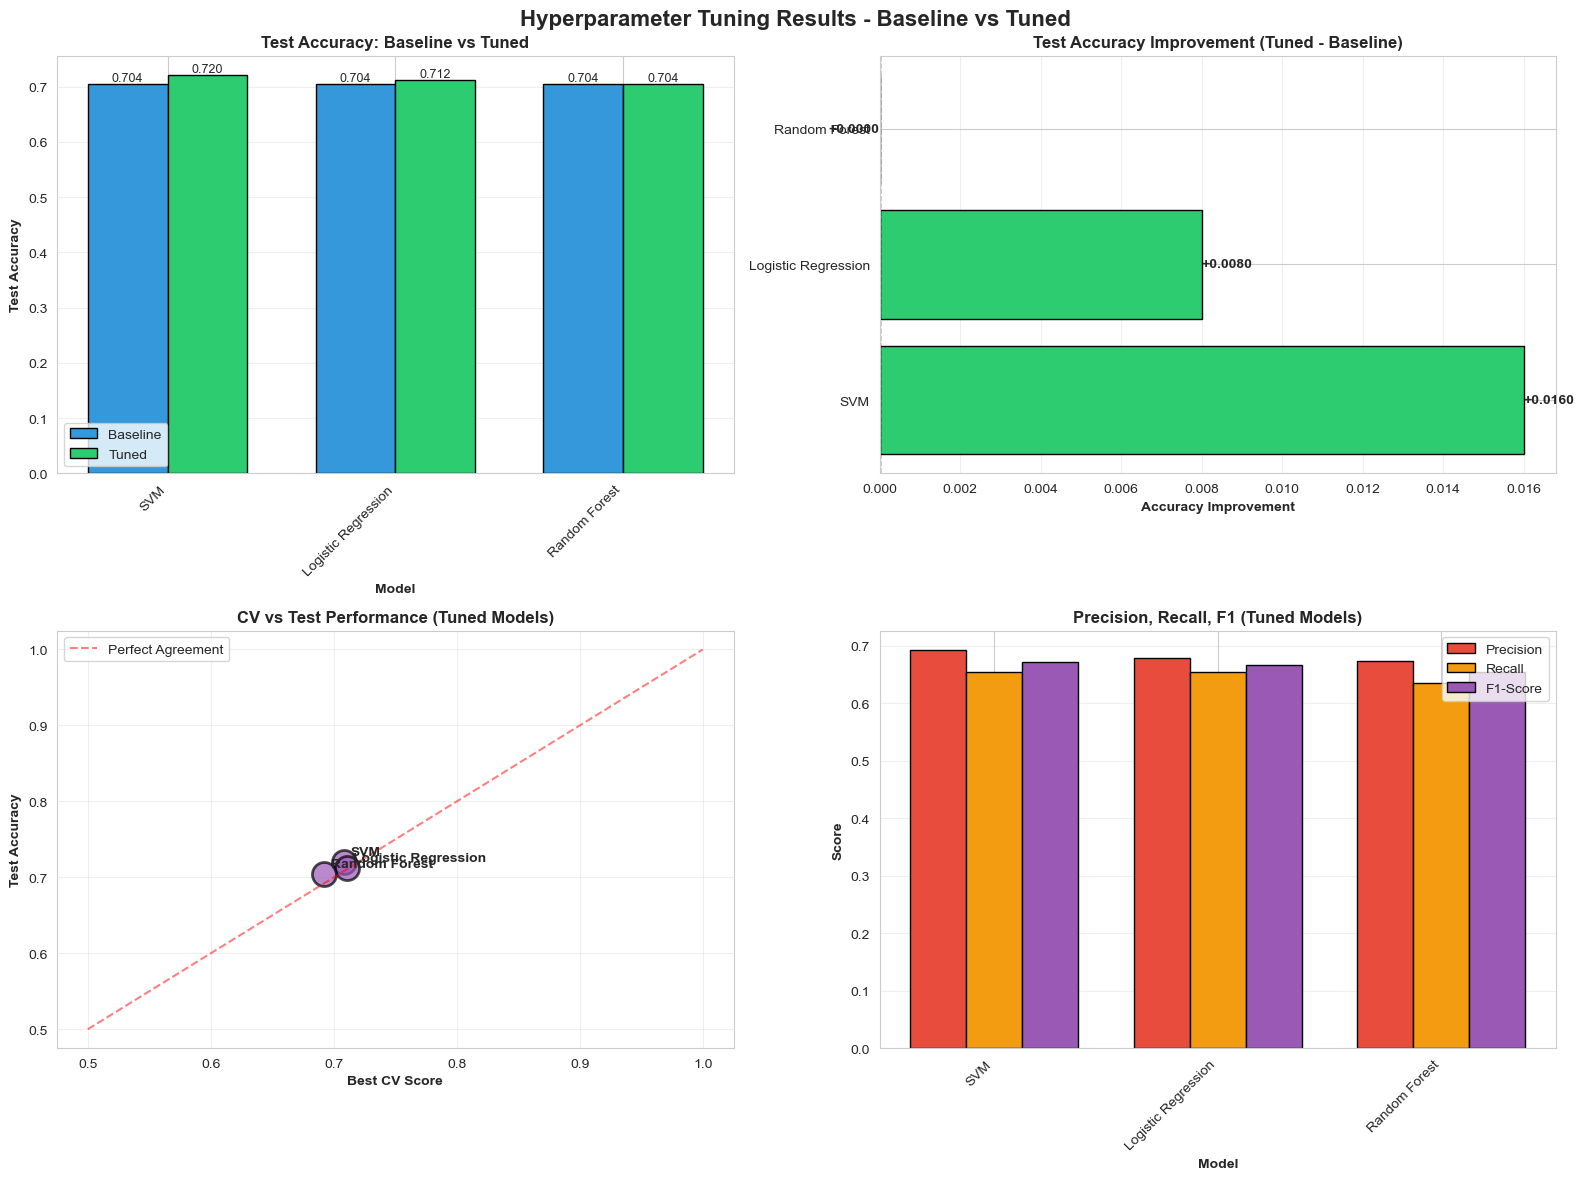

In [16]:
# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hyperparameter Tuning Results - Baseline vs Tuned', fontsize=16, fontweight='bold')

if baseline_results is not None and len(comparison_df) > 0:
    # Baseline vs Tuned Accuracy
    ax1 = axes[0, 0]
    x = np.arange(len(comparison_df))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, comparison_df['Baseline Test Acc'], width, 
                    label='Baseline', color='#3498db', edgecolor='black')
    bars2 = ax1.bar(x + width/2, comparison_df['Tuned Test Acc'], width, 
                    label='Tuned', color='#2ecc71', edgecolor='black')
    
    ax1.set_xlabel('Model', fontweight='bold')
    ax1.set_ylabel('Test Accuracy', fontweight='bold')
    ax1.set_title('Test Accuracy: Baseline vs Tuned', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Accuracy Improvement
    ax2 = axes[0, 1]
    colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in comparison_df['Accuracy Δ']]
    bars = ax2.barh(comparison_df['Model'], comparison_df['Accuracy Δ'], 
                    color=colors, edgecolor='black')
    ax2.set_xlabel('Accuracy Improvement', fontweight='bold')
    ax2.set_title('Test Accuracy Improvement (Tuned - Baseline)', fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax2.grid(axis='x', alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars, comparison_df['Accuracy Δ'])):
        ax2.text(val, bar.get_y() + bar.get_height()/2,
                f'{val:+.4f}', va='center', ha='left' if val > 0 else 'right',
                fontweight='bold', fontsize=10)

# CV Score vs Test Accuracy (Tuned Models)
ax3 = axes[1, 0]
ax3.scatter(tuning_df['Best CV Score'], tuning_df['Test Accuracy'], 
            s=300, c='#9b59b6', edgecolor='black', linewidth=2, alpha=0.7)
for i, model in enumerate(tuning_df['Model']):
    ax3.annotate(model, 
                (tuning_df['Best CV Score'].iloc[i], tuning_df['Test Accuracy'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
ax3.plot([0.5, 1.0], [0.5, 1.0], 'r--', alpha=0.5, label='Perfect Agreement')
ax3.set_xlabel('Best CV Score', fontweight='bold')
ax3.set_ylabel('Test Accuracy', fontweight='bold')
ax3.set_title('CV vs Test Performance (Tuned Models)', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Precision, Recall, F1 for Tuned Models
ax4 = axes[1, 1]
x = np.arange(len(tuning_df))
width = 0.25
bars1 = ax4.bar(x - width, tuning_df['Test Precision'], width, label='Precision', 
                color='#e74c3c', edgecolor='black')
bars2 = ax4.bar(x, tuning_df['Test Recall'], width, label='Recall', 
                color='#f39c12', edgecolor='black')
bars3 = ax4.bar(x + width, tuning_df['Test F1'], width, label='F1-Score', 
                color='#9b59b6', edgecolor='black')

ax4.set_xlabel('Model', fontweight='bold')
ax4.set_ylabel('Score', fontweight='bold')
ax4.set_title('Precision, Recall, F1 (Tuned Models)', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(tuning_df['Model'], rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save figure
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = FIGS / f"hyperparameter_tuning_results_{ts}.png"
fig.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"\nSaved visualization to: {out_path}")

plt.show()


## Save results and Best Model

In [17]:
# Save tuning results
tuning_results_path = REPORTS / "hyperparameter_tuning_results.csv"
tuning_df.to_csv(tuning_results_path, index=False)
print(f"\nTuning results saved to: {tuning_results_path}")

# Save comparison results if available
if baseline_results is not None and len(comparison_df) > 0:
    comparison_path = REPORTS / "baseline_vs_tuned_comparison.csv"
    comparison_df.to_csv(comparison_path, index=False)
    print(f"Comparison results saved to: {comparison_path}")

# Save best tuned model
best_tuned_model = best_models[best_tuned_model_name]
best_model_path = MODELS / "best_model_tuned.pkl"
joblib.dump(best_tuned_model, best_model_path)
print(f"Best tuned model saved to: {best_model_path}")

# Save all tuned models
for model_name, model in best_models.items():
    model_filename = model_name.lower().replace(' ', '_') + '_tuned.pkl'
    model_path = MODELS / model_filename
    joblib.dump(model, model_path)

print(f"All {len(best_models)} tuned models saved to: {MODELS}")

# Save best parameters for each model
best_params_path = REPORTS / "best_hyperparameters.txt"
with open(best_params_path, 'w') as f:
    f.write("BEST HYPERPARAMETERS FOR EACH MODEL\n")
    f.write("="*80 + "\n\n")
    for _, row in tuning_df.iterrows():
        f.write(f"{row['Model']}:\n")
        f.write(f"Test Accuracy: {row['Test Accuracy']:.4f}\n")
        f.write(f"Best Parameters: {row['Best Params']}\n\n")

print(f"Best hyperparameters saved to: {best_params_path}")


Tuning results saved to: /Users/lia/Desktop/Fase1/reports/hyperparameter_tuning_results.csv
Comparison results saved to: /Users/lia/Desktop/Fase1/reports/baseline_vs_tuned_comparison.csv
Best tuned model saved to: /Users/lia/Desktop/Fase1/models/best_model_tuned.pkl
All 3 tuned models saved to: /Users/lia/Desktop/Fase1/models
Best hyperparameters saved to: /Users/lia/Desktop/Fase1/reports/best_hyperparameters.txt


## Tuning Summary

In [18]:
print(f"\n{'='*80}")
print("HYPERPARAMETER TUNING SUMMARY")
print(f"{'='*80}")

print(f"\nTUNING STATISTICS:")
print(f" • Models tuned: {len(models_to_tune)}")
print(f" • Total parameter combinations tested: {sum([np.prod([len(v) for v in m['params'].values()]) for m in models_to_tune.values()])}")
print(f" • CV folds per combination: 5")
print(f" • Total model fits: {sum([np.prod([len(v) for v in m['params'].values()]) * 5 for m in models_to_tune.values()])}")

print(f"\nBEST TUNED MODEL:")
print(f" • Algorithm: {best_tuned_model_name}")
print(f" • Test Accuracy: {best_tuned_accuracy:.4f} ({best_tuned_accuracy*100:.2f}%)")
print(f" • Test F1-Score: {tuning_df.iloc[0]['Test F1']:.4f}")
print(f" • Best CV Score: {tuning_df.iloc[0]['Best CV Score']:.4f}")

if baseline_results is not None and len(comparison_df) > 0:
    best_baseline_acc = baseline_results[baseline_results['Model'] == best_tuned_model_name]['Test Accuracy'].values[0]
    improvement = best_tuned_accuracy - best_baseline_acc
    print(f"\nIMPROVEMENT OVER BASELINE:")
    print(f" • Baseline Accuracy: {best_baseline_acc:.4f}")
    print(f" • Tuned Accuracy: {best_tuned_accuracy:.4f}")
    print(f" • Improvement: {improvement:+.4f} ({improvement*100:+.2f}%)")

print(f"\nARTIFACTS CREATED:")
print(f" ✓ {tuning_results_path.name}")
if baseline_results is not None:
    print(f" ✓ {comparison_path.name}")
print(f" ✓ {best_model_path.name}")
print(f" ✓ {len(best_models)} tuned model files (.pkl)")
print(f" ✓ {best_params_path.name}")
print(f" ✓ 1 visualization (.png)")
print(f" ✓ MLflow tuning experiments logged")

print(f"\nMLFLOW TRACKING:")
print(f" • Experiment: {experiment_name}")
print(f" • Parent runs: {len(models_to_tune)}")
print(f" • Nested runs: ~{sum([5 for _ in models_to_tune])} (top 5 per model)")
print(f" • View UI: Run 'mlflow ui' in project root")



HYPERPARAMETER TUNING SUMMARY

TUNING STATISTICS:
 • Models tuned: 3
 • Total parameter combinations tested: 250
 • CV folds per combination: 5
 • Total model fits: 1250

BEST TUNED MODEL:
 • Algorithm: SVM
 • Test Accuracy: 0.7200 (72.00%)
 • Test F1-Score: 0.6729
 • Best CV Score: 0.7083

IMPROVEMENT OVER BASELINE:
 • Baseline Accuracy: 0.7040
 • Tuned Accuracy: 0.7200
 • Improvement: +0.0160 (+1.60%)

ARTIFACTS CREATED:
 ✓ hyperparameter_tuning_results.csv
 ✓ baseline_vs_tuned_comparison.csv
 ✓ best_model_tuned.pkl
 ✓ 3 tuned model files (.pkl)
 ✓ best_hyperparameters.txt
 ✓ 1 visualization (.png)
 ✓ MLflow tuning experiments logged

MLFLOW TRACKING:
 • Experiment: student_performance_tuning
 • Parent runs: 3
 • Nested runs: ~15 (top 5 per model)
 • View UI: Run 'mlflow ui' in project root
